# Fit Gaussian to Cs-137 Isotope Peak/Compton Edge (vz1)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook fits a Gaussian to Cs-137 run in order to find a value for "sigma" which will be used in the smearing project. The decay rate is also calculated.

### Import needed libraries

In [3]:
import numpy as np

import ROOT
from ROOT import *
import ctypes
from ctypes import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
from scipy.optimize import *
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file 
                                 # named dt5202.py in the lib folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

/home/coure/Din_SmearingProject_Summer2023/libs
/home/coure/Din_SmearingProject_Summer2023


### Declare constants (calculated with $\texttt{MuonPeakCalibration_Din_ThanksEmily_vz1_cut.ipynb}$)

In [7]:
ped = 50 # Pedestal correction for dt5202

# ADC/MeV
adc_mev_cs = 551.0348291637422
adc_mev_bkg = 583.9005065850638
adc_mev_bkg2min = 575.4041720670236

### Load and read lab data from directory

In [5]:
# Import data files
folder = "/data/"

sourceFolder_Cs = folder + "CsSwirlyDin1_20230710/" #Caesium data
sourceFolder_bkg = folder + "BkgSwirlyDin1_10min_20230711/" #Background data
# sourceFolder_Eu = folder + "Eu-152-SwirlyDin1-2min-20230717/" #Europium data
# sourceFolder_Co57 = folder + "Co-57-SwirlyDin1-2min-20230717/" #Co-57
# sourceFolder_Co60 = folder + "Co-60-SwirlyDin1-2min-20230717/" #Co-60
# sourceFolder_bkg2min = folder + "swirlyPanel_2min_bkg/" #Bkg 2 min data

# Importing Ceasium data
onlyfiles_Cs = [f for f in os.listdir(sourceFolder_Cs) if '.dat' in f]
data_list_Cs = []
for file in onlyfiles_Cs:
    data_list_Cs.append(dt5202_crunch(str(sourceFolder_Cs)+str(file), num_ev=10000000, num_ch=1))

data_Cs = data_list_Cs[0]

for j in range(1, len(data_list_Cs)):
    data_Cs = np.append(data_Cs, data_list_Cs[j])
    
# Importing Bkground to Filter out the Caesium Peak
onlyfiles_bkg = [f for f in os.listdir(sourceFolder_bkg) if '.dat' in f]
data_list_bkg = []
for file in onlyfiles_bkg:
    data_list_bkg.append(dt5202_crunch(str(sourceFolder_bkg)+str(file), num_ev=10000000, num_ch=1))

data_bkg = data_list_bkg[0]

for k in range(1, len(data_list_bkg)):
    data_bkg = np.append(data_bkg, data_list_bkg[k])
    
# # Importing 2 min Bkground
# onlyfiles_bkg2min = [f for f in os.listdir(sourceFolder_bkg2min) if '.dat' in f]
# data_list_bkg2min = []
# for file in onlyfiles_bkg2min:
#     data_list_bkg2min.append(dt5202_crunch(str(sourceFolder_bkg2min)+str(file), num_ev=10000000, num_ch=1))

# data_bkg2min = data_list_bkg2min[0]

# for l in range(1, len(data_list_bkg2min)):
#     data_bkg2min = np.append(data_bkg2min, data_list_bkg2min[l])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689019979043)]
((33, 0, 1.68901998e+09, 0, 256), (8, 3, 267, 2716))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689087020711)]
((33, 0, 1.68908702e+09, 0, 256), (8, 3, 3394, 8083))


In [8]:
# Convert data from ADC to MeV

cs_mev = (data_Cs['data']['low_gain']-ped) / adc_mev_cs # Cesium data
bkg_mev = (data_bkg['data']['low_gain']-ped) / adc_mev_bkg # Background
# bkg2min_mev = (data_bkg2min['data']['low_gain']-ped) / adc_mev_bkg2min # Background (2 min)

### Plot Cs-137 data, fit Gaussian with pyROOT

 FCN=981.028 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=9.84404e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.4 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.58821e+05   2.08097e+02  -3.63435e+00  -2.62925e-06
   2  Mean         3.17151e-01   1.50669e-04   9.48862e-06  -3.71388e+00
   3  Sigma        1.60073e-01   1.09917e-04  -1.35415e-06  -9.25851e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian Fit (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).


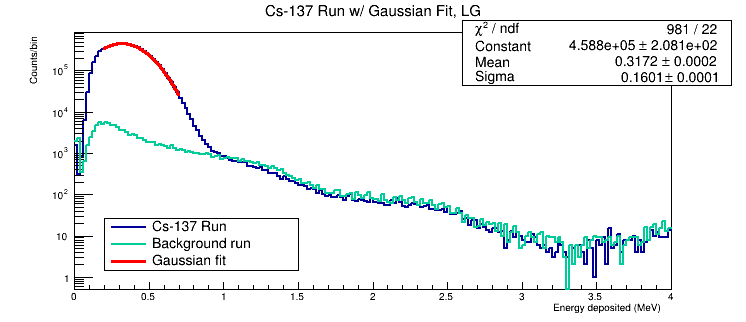

In [15]:
# Turn cs_mev into a ROOT Histogram
c2 = ROOT.TCanvas('c2','', 750, 350)
cs_hpx = ROOT.TH1D('Gaussian Fit', 'Cs-137 Run w/ Gaussian Fit, LG', 200, 0, 4)
bkg_hpx = ROOT.TH1D('bkg', 'bkg', 200, 0, 4)
fill_hist(cs_hpx, cs_mev)
fill_hist(bkg_hpx, bkg_mev)

# Define Gaussian as a custom function, this will be convenient later
gaussian = ROOT.TF1("gaussian","[0] * exp((-(x-[1])**2)/(2*[2]**2))", 0.2, 0.7)
gaussian.SetParameters(2.8*10**5, 0.3, 0.15)
gaussian.SetParNames("Constant", "Mean", "Sigma")
gaussian.SetTitle("Gaussian Fit")

# Draw the function
cs_hpx.Draw()
cs_hpx.GetXaxis().SetTitle("Energy deposited (MeV)")
cs_hpx.GetYaxis().SetTitle("Counts/bin")
ROOT.gPad.SetLogy()
# ROOT.gPad.SetGridx()
ROOT.gStyle.SetOptStat(0)
cs_hpx.Fit("gaussian","R")
# gaussian.SetLineWidth()
gaussian.Draw("same")
gaussian.SetLineWidth(3)
ROOT.gStyle.SetOptFit()
bkg_hpx.Draw("same")
cs_hpx.SetLineWidth(2)
cs_hpx.SetLineColor(kBlue+2)

bkg_hpx.SetLineColor(kTeal-1)
bkg_hpx.SetLineWidth(2)

legend = ROOT.TLegend(0.14,0.16,0.4,0.32)
legend.AddEntry(cs_hpx,"Cs-137 Run","l")
legend.AddEntry(bkg_hpx,"Background run","l")
legend.AddEntry(gaussian,"Gaussian fit","l")
legend.Draw()

c2.Draw()
# c2.SaveAs("Cs137GaussFit_vz3.png")

In [21]:
gaussian.GetParameter('Sigma')

0.16007343258163068

In [36]:
binWidth = cs_hpx.GetBinWidth(1)
print(binWidth)
cs_dr = (gaussian.Integral(0.2, 0.7))/(10*60*binWidth)
print("Decay rate of Cs-137 source: %0.3f/sec"%cs_dr)

0.011000000000000001
Decay rate of Cs-137 source: 11636.944/sec


NOTE: Pause for now, ran into complication with the way Cs-137 source decays. Talk to Jorge to see where to go from here. Value of sigma is good though!